BEFORE Running:
1. Please install the required libraries before proceeding. On Colab, you may directly use the below cell to install all dependencies. 
2. On a local machine, ensure torch, tansformers, trl, bitsandbytes, accelerate, peft, datasets, huggingface_hub, hf_transfer are installed. 

Instructions for running:
1. The notebook is written for Colab, and assumes the data for DPo and SFT model is present in the directory 'PROJECT_DIR' = '/content/drive/MyDrive/cs776-project'
2. It retrieves the SFT model and the DPO training data from drive and aligns the SFT model using DPO.

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
import torch

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "CPU"
print(DEVICE)

cuda


In [4]:
# from peft import get_peft_model, LoraConfig
from transformers import AutoModelForVision2Seq, AutoProcessor
from transformers.image_utils import load_image
from datasets import features, load_dataset
from trl import DPOConfig, DPOTrainer
import gc
import datasets
from transformers import pipeline

In [5]:
from google.colab import drive
drive.mount('/content/drive')
image_dir = "/content/drive/MyDrive/cs776-project/filtered_images"
train_data_file = "/content/drive/MyDrive/cs776-project/train_cot_updated.json"

PROJECT_DIR = '/content/drive/MyDrive/cs776-project'

Mounted at /content/drive


In [6]:
SMALL = True
data_dir = PROJECT_DIR + '/DPO_dataset_256M_SFT_smolcot_ep2_high_lr'

Load the models.  
In DPO, the model needs to be loaded twice - once as a reference, and one model which is actually modified.
Also load the processor which tokenizes the text

In [7]:
model_id = None
if SMALL:
  model_id = PROJECT_DIR + "/SFT_256M_smolcot_ep2_high_lr"
  model_processor = "HuggingFaceTB/SmolVLM-256M-Instruct"
else:
  # model_id = "HuggingFaceTB/SmolVLM-500M-Instruct"
  model_id = PROJECT_DIR + '/SFT_500M_smolcot_on_3k'
  model_processor = "HuggingFaceTB/SmolVLM-500M-Instruct"

model_ref = AutoModelForVision2Seq.from_pretrained(model_id).to(DEVICE)
model = AutoModelForVision2Seq.from_pretrained(model_id).to(DEVICE)
processor = AutoProcessor.from_pretrained(model_processor, do_image_splitting=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.55M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Load the prepared DPO dataset - prepared from the 'DPO_dataset_prep' notebook

In [8]:
import datasets
dataset = datasets.load_from_disk(data_dir)

In [9]:
dataset[0]

{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=309x385>],
 'prompt': "<|im_start|>User:<image>Your task is to answer question based on the attached image.\nUse this format to answer the question: <think>[Reasoning steps]</think> <answer>[Concise answer]</answer>.\nPut your thinking inside <think> tags and then a concise(single word/phrase/numeric) answer inside <answer> tags.\nQuestion:\n\nWhat is the ratio of the total of 'Very' to 'Somewhat'?<end_of_utterance>\n",
 'chosen': "<|im_start|>Assistant: <think>\nThe user is asking for the ratio of the sum of 'Very' values to the sum of 'Somewhat' values from the bar chart.\nI need to sum up all the 'Very' values and all the 'Somewhat' values separately and then calculate their ratio.\nSum of 'Somewhat' = 22 + 18 + 14 + 26 + 23 + 25 + 22 = 150\nSum of 'Very' = 42 + 18 + 18 + 17 + 64 + 62 + 67 = 288\nRatio = Sum of 'Very' / Sum of 'Somewhat' = 288 / 150 = 1.92\n</think>\n\n<answer>\n1.92\n</answer><end_of_utterance>\n",
 '

In [10]:
f = dataset.features
f["images"] = features.Sequence(features.Image(decode=True))  # to avoid bytes
dataset = dataset.cast(f)

Casting the dataset:   0%|          | 0/1700 [00:00<?, ? examples/s]

In [11]:
dataset[0]

{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=309x385>],
 'prompt': "<|im_start|>User:<image>Your task is to answer question based on the attached image.\nUse this format to answer the question: <think>[Reasoning steps]</think> <answer>[Concise answer]</answer>.\nPut your thinking inside <think> tags and then a concise(single word/phrase/numeric) answer inside <answer> tags.\nQuestion:\n\nWhat is the ratio of the total of 'Very' to 'Somewhat'?<end_of_utterance>\n",
 'chosen': "<|im_start|>Assistant: <think>\nThe user is asking for the ratio of the sum of 'Very' values to the sum of 'Somewhat' values from the bar chart.\nI need to sum up all the 'Very' values and all the 'Somewhat' values separately and then calculate their ratio.\nSum of 'Somewhat' = 22 + 18 + 14 + 26 + 23 + 25 + 22 = 150\nSum of 'Very' = 42 + 18 + 18 + 17 + 64 + 62 + 67 = 288\nRatio = Sum of 'Very' / Sum of 'Somewhat' = 288 / 150 = 1.92\n</think>\n\n<answer>\n1.92\n</answer><end_of_utterance>\n",
 '

Split it into training and evaluation sets

In [12]:
split_dataset = dataset.train_test_split(test_size=0.05, seed=3407) # Use the same seed for reproducibility
train_data = split_dataset['train']
eval_data = split_dataset['test']

Prepare the DPO Trainer class and it's training hyperparameters. Set checkpointing and eval strategies, learning rate, max new tokens per query, etc.

In [13]:
# set the configuration parameters for the DPO trainer class
training_args = DPOConfig(
    # checkpointing
    save_strategy="steps",        # When to save (options: "steps", "epoch", or "no")
    save_steps=30,               # Save a checkpoint every 100 steps (adjust as needed)
    save_total_limit=5,           # Maximum number of checkpoints to keep
    load_best_model_at_end=True,  # Load the best model at the end of training

    # If you want to evaluate and save based on the best model:
    eval_strategy="steps",  # When to run evaluation
    eval_steps=5,               # Run evaluation every 100 steps (typically same as save_steps)
    metric_for_best_model="eval_loss", # Metric to use for determining the best model

    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    warmup_steps = 5,
    num_train_epochs=1.2,
    fp16 = False,
    bf16=False,
    logging_steps = 1,

    optim = "paged_adamw_8bit",
    weight_decay = 0.01,
    learning_rate = 2e-5,
    lr_scheduler_type = "linear",
    seed = 3407,

    output_dir="dpo_log_outputs_smolcot",
    report_to="none",
    # gradient_checkpointing=True,

    # remove_unused_columns = False,
    max_length = 2048,
    # dataset_text_field = "",
    # dataset_kwargs = {"skip_prepare_dataset": True},
    dataset_num_proc=2,  # tokenization will use 2 processes
    dataloader_num_workers=2,  # data loading will use 2 workers
)

In [14]:
# init the DPOTrainer. train and save the model
trainer = DPOTrainer(
    model,
    # data_collator = UnslothVisionDataCollator(model, processor), # Must use!
    train_dataset = train_data,
    eval_dataset = eval_data,
    ref_model=model_ref,
    args=training_args,
    processing_class=processor,
)

print("starting train")
trainer_stats = trainer.train()
print("train done")
trainer.save_model(PROJECT_DIR + "/DPO_256M_updated_checkpoint_smolcot")

Extracting prompt in train dataset (num_proc=2):   0%|          | 0/1615 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/1615 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/1615 [00:00<?, ? examples/s]

Extracting prompt in eval dataset (num_proc=2):   0%|          | 0/85 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/85 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/85 [00:00<?, ? examples/s]

starting train


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
5,0.053600,0.081625,2.545166,-1.542131,1.000000,4.087296,-178.600891,-86.555435,2.096164,1.694765
10,0.000100,0.016589,4.198936,-3.951833,1.000000,8.150771,-162.063187,-110.652466,1.280898,1.208351
15,0.000300,0.010589,4.546318,-4.955635,1.000000,9.501953,-158.589371,-120.690475,1.178017,1.257167
20,0.000000,0.007347,4.698357,-5.492790,1.000000,10.191148,-157.068985,-126.062035,1.120554,1.254132
25,0.000000,0.008138,4.747397,-5.807692,1.000000,10.555088,-156.578583,-129.211060,1.066752,1.237276
30,0.000100,0.006513,4.785359,-6.002214,1.000000,10.787574,-156.198959,-131.156265,1.030317,1.223829
35,0.000000,0.005886,4.808614,-6.130389,1.000000,10.939004,-155.966400,-132.438019,1.006057,1.216411
40,0.000000,0.005680,4.821821,-6.229950,1.000000,11.051771,-155.834335,-133.433609,0.991079,1.207754
45,0.000000,0.005587,4.830902,-6.307479,1.000000,11.138381,-155.743546,-134.208923,0.981310,1.197860
50,0.000000,0.005535,4.836792,-6.362229,1.000000,11.199020,-155.684631,-134.756439,0.974694,1.189152


train done


In [15]:
# free the memory and GPU memory to make space
import gc
model = None
model_ref = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

Manual evaluation. For 256M we did not see good results with DPO

In [16]:
# Load the model after the training and the test images
image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
image2 = load_image("https://huggingface.co/spaces/merve/chameleon-7b/resolve/main/bee.jpg")

model = AutoModelForVision2Seq.from_pretrained(
    PROJECT_DIR + "/DPO_256M_updated_checkpoint_smolcot",
    torch_dtype=None
).to(DEVICE)

In [17]:
# Evaluate after doing DPO-RL training
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe the two images?"}
        ]
    },
]

prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
inputs = inputs.to(DEVICE)
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

User:Can you describe the two images?
Assistant: The image contains a statue of the Statue of Liberty, which is a prominent landmark in New York City. The statue is located on the Liberty Island, a small island in New York City. The statue is made of bronze and is currently in the process of being restored.

The statue is surrounded by a large crowd of people, who are watching the restoration process. The crowd is enthusiastic and enthusiastic, and they are all looking at the statue with admiration and awe.

In the background, there are several other landmarks and structures, including the Statue of Liberty itself, the Empire State Building, and the Statue of Liberty itself. The sky is clear and blue, indicating good weather.

The image is taken from a slightly elevated position, which gives a good view of the statue and the surrounding area. The lighting is bright and even, which highlights the details of the statue and the surrounding environment.

### Analysis

The image is a photog

In [18]:
print("done")

done


In [21]:
!ls /content/drive/MyDrive/cs776-project

ChartQADataset.zip			  Project-Lit-review-CS776.gdoc
DPO_256M_updated_checkpoint_smolcot	  README.gdoc
DPO_dataset				  SFT_256M_smolcot_ep2_high_lr
DPO_dataset_256M_SFT_smolcot_ep2_high_lr  SFT_500M_smolcot_on_3k
DPO_dataset_500M_SFT_manual_download	  SFT_500M_updated_checkpoint
filtered_data_4k.json			  SFT_checkpoint
filtered_data_5k.json			  SFT_updated_checkpoint
filtered_data.json			  system_prompt.md
filtered_images				  test_data.json
filtered_images_4k			  tiny_system_prompt.md.gdoc
filtered_images_5k			  train_cot_traces.json
GRPO					  train_cot_updated.json
hf_data_5k				  train_data.json
hf_data_updated				  training_args.bin
hf_data_version				  train_smolcot_3k_p1.json
new_train_smolcot_hf_1700		  train_traces_5k.json


In [22]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
data_final_eval = datasets.load_from_disk(PROJECT_DIR + "/eval_smolcot_hf")
len(data_final_eval)

150

In [24]:
org_model = AutoModelForVision2Seq.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct").to(DEVICE)

config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [25]:
sft_model = AutoModelForVision2Seq.from_pretrained(PROJECT_DIR + "/SFT_256M_smolcot_ep2_high_lr").to(DEVICE)

What is the mode of the data points?
<think>
The user is asking to find the mode of the data points in the line chart.
The data points are the values shown on the line, which are 36, 28, 25, 21, 15, 9, and 9.
The mode is the value that appears most frequently in the data set. In this dataset, 9 appears twice, which is more frequent than any other value.
</think>

<answer>
9
</answer>


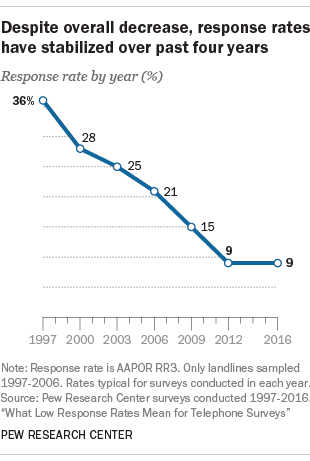

In [36]:
x = 40    #99, 100, 23, 27, 33, 35, 37, 40
qs = data_final_eval[x]["messages"][0]["content"][0]["text"]
print(qs)
print(data_final_eval[x]["messages"][1]["content"][0]["text"])
image = data_final_eval[x]["images"][0]

image

In [37]:
old = qs
# qs = "What is sum of percentage of NatWest Group and Coventry BS?"

# qs += " think and then answer"
# qs += "Let's solve this step by step"
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": f"{qs}"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
with torch.no_grad():
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    generated_ids = org_model.generate(**inputs
    # generated_ids = model.generate(**inputs
                                   , max_new_tokens = 256
                                   )
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,

    )

print("----------------\nBASE Model:\n----------------")
print(generated_texts[0])

print("==========================")
with torch.no_grad():
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    # generated_ids = org_model.generate(**inputs
    generated_ids = sft_model.generate(**inputs
                                   , max_new_tokens = 256
                                   )
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,

    )

print("----------------\nSFT Model:\n----------------")
print(generated_texts[0].partition("Assistant:")[2].strip())
print("==========================")
with torch.no_grad():
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    # generated_ids = org_model.generate(**inputs
    generated_ids = model.generate(**inputs
                                   , max_new_tokens = 256
                                   )
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,

    )

print("----------------\nDPO Model:\n----------------")
print(generated_texts[0].partition("Assistant:")[2].strip())
qs = old

----------------
BASE Model:
----------------
User:What is the mode of the data points?
Assistant: The mode is the value that appears most often in a set of data. In this case, the mode is 9, which is the value that occurs most often.
----------------
SFT Model:
----------------
The mode of the data points is 9.
----------------
DPO Model:
----------------
The mode is the value that appears most often in the data. The data points are all values between 21 and 25. The value 21 appears most often.
The mode is 21.
Answer: 21.

## Answer:
The user is asking for the value that appears most often in the data.
The data points are all values between 21 and 25.
The value 21 appears most often.

## Answer:
The mode is 21.
## Answer:
The answer is: 21

## Detailed Answer:
The user is asking for the value that appears most often in the data.
The data points are all values between 21 and 25.
The value 21 appears most often.

## Answer:
The mode is 21.

## Answer:
The mode is 21.

## Answer:
The use